In [99]:
import sys
sys.path.append('../')

import pandas as pd 
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

from classic_descriptors.featurisation import process_dataframe
from analysis import analysis_stratification_influence, analysis_train_set_size, analysis_stratification_influence_substrates, get_raw_results, analysis_stratification_influence_substrates_raw

from sklearn.metrics import mean_absolute_error, accuracy_score, balanced_accuracy_score, explained_variance_score, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')


In [100]:
import dft_descriptors.prepocessing as pp
import dft_descriptors.featurisation as ft

In [101]:
df = pd.read_csv("data_csv/Data_test11222021.csv", sep = ',')
# Removing 
vc = df.DOI.value_counts()
doi_above_10 = np.array(vc[vc > 20].index)

indexes = []

for i, row in df.iterrows():
    if row["DOI"] not in doi_above_10:
        indexes.append(i)
        
df = df.drop(indexes)
df = df.reset_index(drop=True)

In [102]:
df2 = pp.preprocess(df)
df2["Lewis Acid"] = df2["Lewis Acid"].fillna('NoLewisAcid')
df2["Lewis Acid"] = df2["Lewis Acid"].replace('nan', 'NoLewisAcid')

In [103]:
Lewis_Acids_to_drop = ['O=C(O[Cs])O[Cs]', 'Cl[Cs]', 
                       'O=S(=O)(O[Sc](OS(=O)(=O)C(F)(F)F)OS(=O)(=O)C(F)(F)F)C(F)(F)F', 
                       'F[Cs]', 'O=P(O[Na])(O[Na])O[Na]', '[Rb+]',
                       'CC(C)(C)C(=O)O[Cs]', '[Cs+]', 'CC(=O)O[Cu]OC(C)=O', 'F[Sr]F']

In [104]:
for al in Lewis_Acids_to_drop:
    df2 = df2[df2["Lewis Acid"] != al]
    
df2 = df2.reset_index(drop=True)

In [105]:
vc =df2.DOI.value_counts()
doi_above_10 = np.array(vc[vc > 20].index)

indexes = []

for i, row in df2.iterrows():
    if row["DOI"] not in doi_above_10:
        indexes.append(i)
        
df2 = df2.drop(indexes)
df2 = df2.reset_index(drop=True)

In [107]:
import copy
X_o, y, DOIs, mechanisms, origins = ft.process_dataframe_dft(copy.copy(df2), data_path="data_csv/", origin=True)
X, y, DOIs, mechanisms, origins = ft.process_dataframe_dft(df2, data_path="data_csv/", origin=False)

NoLigand
NoLigand


In [8]:
for i in range(1419):
    if np.count_nonzero(np.isnan(X_o[i])) != 0:
        print(i, np.count_nonzero(np.isnan(X_o[i])))

In [ ]:
X_o[1369]

In [ ]:
X_o.shape

In [108]:
estimators = [('predictor', RandomForestRegressor())]
pipe = Pipeline(estimators)
metric = r2_score

# 1. Yields distribution by origin and mechanism

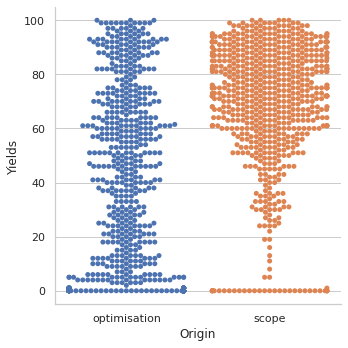

In [109]:
# Yield distribution according to scope/optimization
display_df =  pd.DataFrame(zip(y, mechanisms, origins), columns =['Yields', 'Mechanisms', 'Origin'])

sns.catplot(y="Yields", data=display_df, x='Origin',  kind="swarm")
plt.show()

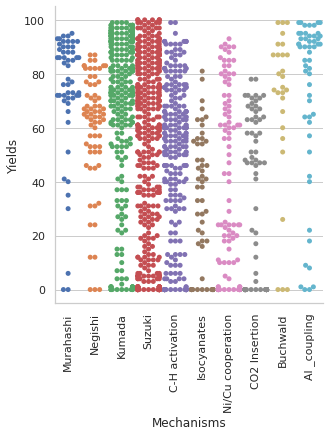

In [110]:
# Yield distribution according to mechanism
chart = sns.catplot(y="Yields", data=display_df, x='Mechanisms',  kind="swarm")
for axes in chart.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.show()

In [111]:
metric_values, baseline_values, sizes = analysis_train_set_size(X, y, DOIs, metric=metric, predictor=pipe, n_iterations_external=4, n_iterations_internal=4)
#metric_values_o, baseline_values_o, sizes_o = analysis_train_set_size(X_o, y, DOIs, metric=metric, predictor=pipe, n_iterations_external=3, n_iterations_internal=10)

In [112]:
metric_mean = np.mean(metric_values, axis=1)
metric_lower = np.percentile(metric_values, 5, axis=1)
metric_upper = np.percentile(metric_values, 95, axis=1)

baseline_mean = np.mean(baseline_values, axis=1)
baseline_lower = np.percentile(baseline_values, 5, axis=1)
baseline_upper = np.percentile(baseline_values, 95, axis=1)

#metric_mean_o = np.mean(metric_values_o, axis=1)
#metric_lower_o = np.percentile(metric_values_o, 5, axis=1)
#metric_upper_o = np.percentile(metric_values_o, 95, axis=1)

# 2. Evolution of performance with training data availibility

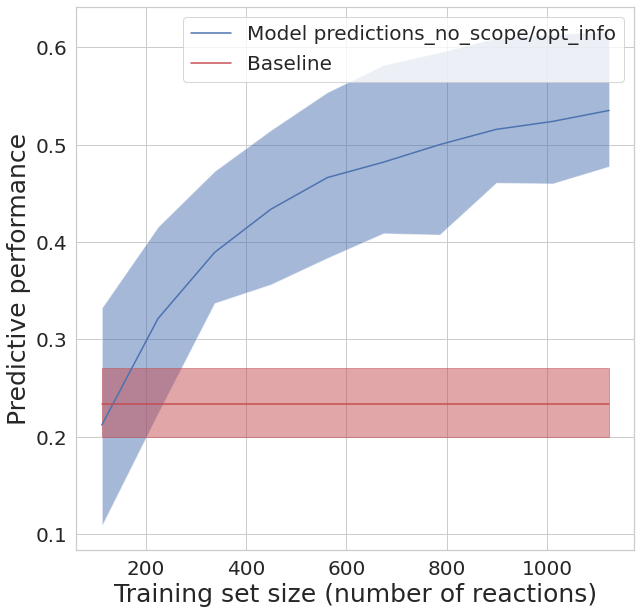

In [113]:
# How does (with fixed test set) performance improves as the training set size augments?
plt.figure(figsize=(10, 10))

plt.plot(sizes, metric_mean, label='Model predictions_no_scope/opt_info')
plt.fill_between(sizes, metric_lower, metric_upper, alpha=0.5)

#plt.plot(sizes_o, metric_mean_o, label='Model predictions_scope/opt_info')
#plt.fill_between(sizes_o, metric_lower_o, metric_upper_o, alpha=0.5)

plt.plot(sizes, baseline_mean, c='r', label='Baseline')
plt.fill_between(sizes, baseline_lower, baseline_upper, color='r', alpha=0.5)

plt.xlabel("Training set size (number of reactions)", fontsize=25)
plt.ylabel("Predictive performance", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.show()

# 3. In-depth analysis of the results 

In [114]:
values, baseline_values, model_values, stratification_values, additional_stratification_values = get_raw_results(X, y, origins, mechanisms, n_iterations=5)

In [115]:
display_df =  pd.DataFrame(zip(values, baseline_values, model_values, stratification_values, additional_stratification_values), columns = ['Yields', 'Baseline', 'Global model', 'Origin', 'Mechanism'])

## Breakdown by optimisation/scope 

Optimisation results: 0.45841582361059063
Scope results: 0.24015795297842346


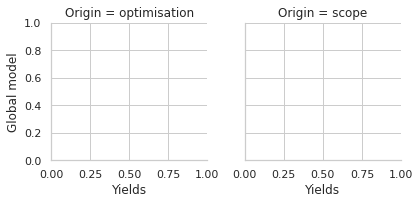

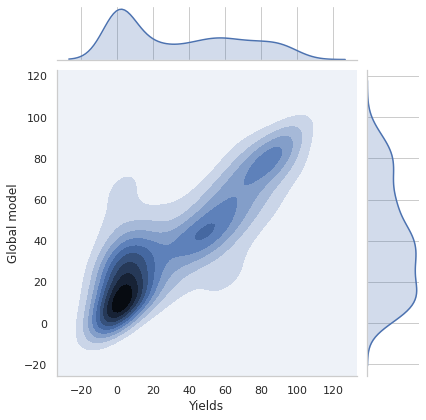

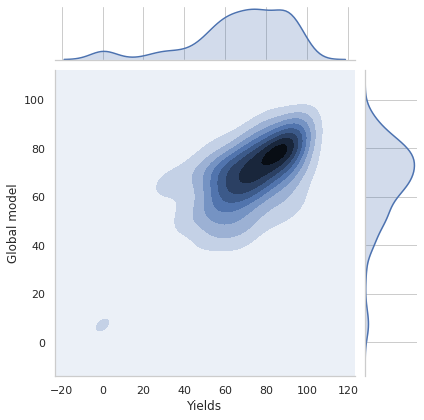

In [116]:
g = sns.FacetGrid(display_df, col="Origin")
g.map(sns.jointplot, "Yields", "Global model", kind='kde')
indexes = np.where(np.array(stratification_values)=='optimisation')
print("Optimisation results: {}".format(metric(np.array(values)[indexes], np.array(model_values)[indexes])))
indexes = np.where(np.array(stratification_values)=='scope')
print("Scope results: {}".format(metric(np.array(values)[indexes], np.array(model_values)[indexes])))

## Breakdown by mechanism

Al _coupling results: 0.4099146493343445
Buchwald results: 0.24376185921117122
C-H activation results: 0.594255301886794
CO2 Insertion results: 0.4397791081721052
Isocyanates results: 0.5204180591706786
Kumada results: 0.5481478833555393
Murahashi results: 0.10169435887747058
Negishi results: 0.7208550922083979
Ni/Cu cooperation results: 0.6067767579722614
Suzuki results: 0.3807612267818822


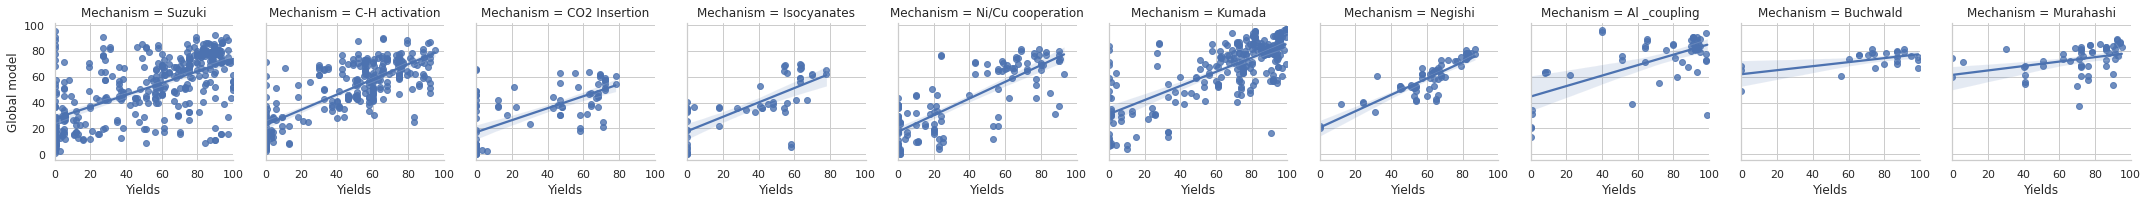

In [ ]:
g = sns.FacetGrid(display_df, col="Mechanism")
g.map(sns.regplot, "Yields", "Global model")
for mecha in np.unique(additional_stratification_values):
    indexes = np.where(np.array(additional_stratification_values)==mecha)
    print("{} results: {}".format(mecha, metric(np.array(values)[indexes], np.array(model_values)[indexes])))


# 4. Comparing global, local and mechanism models across training sizes

In [ ]:
from analysis import analysis_stratification_influence_raw

In [152]:
values = []
predicted = []
errors = []
test_sizes = []
model = []
doi = []

for test_size in np.linspace(0.1, 0.9, 2):
    stratification_results_raw, additional_stratification_results_raw, local_results_raw, global_results_raw, local_baseline_results_raw, values_raw = analysis_stratification_influence_raw(X, y, DOIs, origins, metric=metric, predictor=pipe,
                                          test_size=test_size, n_iterations=1)
    values.extend(values_raw + values_raw)
    predicted.extend(global_results_raw + local_results_raw)
    model.extend(["Global"]*len(global_results_raw) + ["Local"]*len(local_results_raw) )
    doi.extend(stratification_results_raw + stratification_results_raw)
    test_sizes.extend([test_size]*len(values_raw) + [test_size]*len(values_raw))

In [153]:
display_df =  pd.DataFrame(zip(values, predicted, test_sizes, model, np.abs(np.array(predicted) - np.array(values)), doi), columns = ['Yields', 'Predictions', 'Test size', 'Model', 'Errors', 'DOI'])

## Split by DOI, analysis where results are grouped by DOI (each DOI has same weight in the distribution)

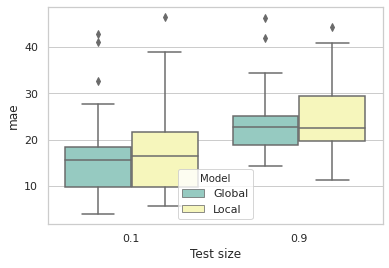

In [154]:
def r2_rmse(g):
    r2 = r2_score(g['Yields'], g['Predictions'])
    mae = mean_absolute_error(g['Yields'], g['Predictions'])
    rmse = np.sqrt(mean_squared_error(g['Yields'], g['Predictions']))
    return pd.Series(dict(r2 = r2, rmse = rmse, mae=mae))
grouped_multiple = display_df.groupby(['DOI', 'Test size', 'Model']).apply(r2_rmse).reset_index()

sns.boxplot(x="Test size", y="mae", hue="Model",
                 data=grouped_multiple, palette="Set3") 

## Split by DOI, analysis where results are not grouped by DOI (each reaction has same weight in the distribution)

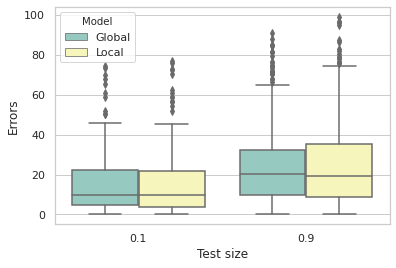

In [155]:
sns.boxplot(x="Test size", y="Errors", hue="Model",
                 data=display_df, palette="Set3")

In [156]:
values_mechanism = []
predicted_mechanism = []
errors_mechanism = []
test_sizes_mechanism = []
model_mechanism = []
doi_mechanism = []

for test_size in np.linspace(0.1, 0.9, 9):
    stratification_results_raw, additional_stratification_results_raw, local_results_raw, global_results_raw, local_baseline_results_raw, values_raw = analysis_stratification_influence_raw(X, y, DOIs, origins, metric=metric, predictor=pipe,
                                          test_size=test_size, n_iterations=1)
    values_mechanism.extend(values_raw + values_raw)
    predicted_mechanism.extend(global_results_raw + local_results_raw)
    model_mechanism.extend(["Global"]*len(global_results_raw) + ["Local"]*len(local_results_raw) )
    doi_mechanism.extend(stratification_results_raw + stratification_results_raw)
    test_sizes_mechanism.extend([test_size]*len(values_raw) + [test_size]*len(values_raw))

In [159]:
display_df_mechanism =  pd.DataFrame(zip(values_mechanism, predicted_mechanism, [round(x, 2) for x in test_sizes_mechanism], model_mechanism, np.abs(np.array(predicted_mechanism) - np.array(values_mechanism)), doi_mechanism), columns = ['Yields', 'Predictions', 'Test size', 'Model', 'Errors', 'DOI'])

## Split by mechanism, analysis where results are grouped by DOI (each mechanism has same weight in the distribution)

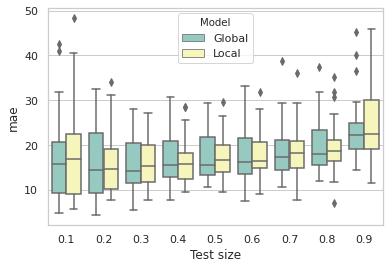

In [160]:
def r2_rmse(g):
    r2 = r2_score(g['Yields'], g['Predictions'])
    mae = mean_absolute_error(g['Yields'], g['Predictions'])
    rmse = np.sqrt(mean_squared_error(g['Yields'], g['Predictions']))
    return pd.Series(dict(r2 = r2, rmse = rmse, mae=mae))
grouped_multiple = display_df_mechanism.groupby(['DOI', 'Test size', 'Model']).apply(r2_rmse).reset_index()

sns.boxplot(x="Test size", y="mae", hue="Model",
                 data=grouped_multiple, palette="Set3") 

## Split by mechanism, analysis where results are not grouped by mechanism (each reaction has same weight in the distribution)

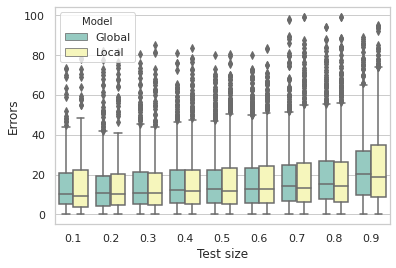

In [162]:
sns.boxplot(x="Test size", y="Errors", hue="Model",
                 data=display_df_mechanism, palette="Set3")

# 5. Analysis of substrate splits 

In [139]:
vc = df2.DOI.value_counts()
indexes = np.where(np.array(df2['type of data (Optimisation or scope)'])=='Optimisation')[0]
df_scope = df2.drop(indexes)
df_scope = df_scope.reset_index(drop=True)

In [165]:
X_scope, y_scope, DOIs_scope, mechanisms_scope, origins_scope = ft.process_dataframe_dft(df2, data_path="data_csv/", origin=False)

NoLigand


In [166]:
stratification_results, additional_stratification_results, global_results, global_baseline_results, values = analysis_stratification_influence_substrates_raw(X_scope, y_scope, list(df_scope["Reactant Smile (C-O)"]), 
origins_scope, metric=metric, predictor=RandomForestRegressor(), test_size=0.2, n_iterations=3)

In [167]:
display_df_scope =  pd.DataFrame(zip(stratification_results, additional_stratification_results, global_results, global_baseline_results, values), columns =['DOI', 'Origin', 'Global model', 'Global baseline', 'Yields'])

Scope results: 0.5047292552080584


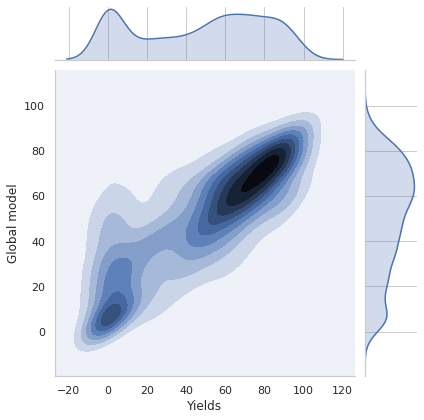

In [168]:
print("Scope results: {}".format(metric(np.array(values), np.array(global_results))))
sns.jointplot(data = display_df_scope, x="Yields", y="Global model", kind = 'kde', hue="Origin")

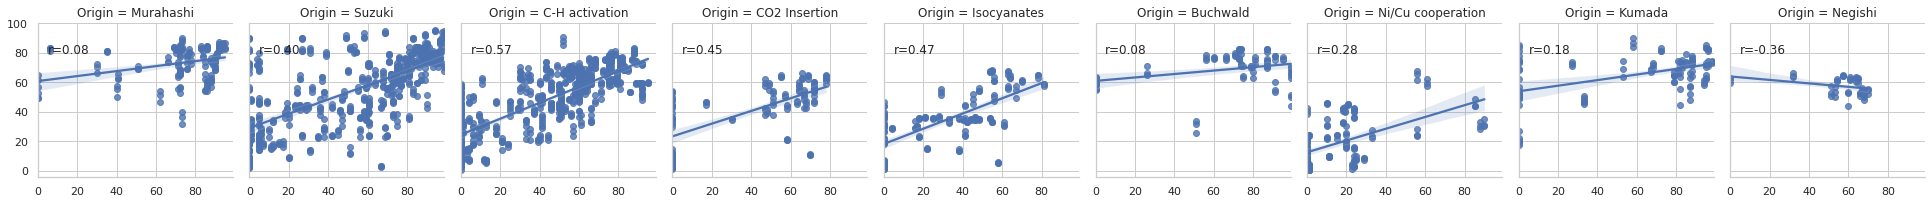

In [170]:

g = sns.FacetGrid(display_df_scope, col="Origin")
g.map_dataframe(sns.regplot, x="Yields", y="Global model")
def annotate(data, **kws):
    r = r2_score(data['Yields'], data['Global model'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}'.format(r),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)

In [169]:
# Substrate split avec que réactif et AX 

# Other experiments! Discard what is not needed 

In [ ]:
# Evolution avec nombre de datapoints avec DOI only, mecha, global et baseline 

In [ ]:
metric_standalone, metric_augmented, metric_baseline_standalone, metric_baseline_augmented, unique_stratification, sizes = analysis_stratification_influence(X, y, DOIs, metric=metric, predictor = pipe, test_size=0.95, n_iterations=2)

In [ ]:
metric_augmented = np.mean(metric_augmented, axis=1)
metric_standalone = np.mean(metric_standalone, axis=1)
metric_baseline_standalone = np.mean(metric_baseline_standalone, axis=1)

In [ ]:
metric_mechanism, metric_augmented_mechanism, metric_baseline_mechanism, _, unique_stratification_mechanism, sizes_mechanism = analysis_stratification_influence(X, y, mechanisms, metric=metric, predictor = pipe, test_size=0.2, n_iterations=2)

In [ ]:
metric_augmented_mechanism = np.mean(metric_augmented_mechanism, axis=1)
metric_mechanism = np.mean(metric_mechanism, axis=1)
metric_baseline_mechanism = np.mean(metric_baseline_mechanism, axis=1)

In [ ]:
def doi_2_mechanism(DOIs, doi):
    dois_indexes = np.where(DOIs==doi)[0]
    mechanism = mechanisms[dois_indexes[0]]
    return mechanism

def doi_2_origin(DOIs, doi):
    dois_indexes = np.where(DOIs==doi)[0]
    origin = origins[dois_indexes[0]]
    return origin

mecha = [doi_2_mechanism(DOIs, x) for x in unique_stratification]
orig = [doi_2_origin(DOIs, x) for x in unique_stratification]

In [ ]:
# Comparison of performance (distribution by DOI) of global, local and baseline models, stratified by mechanism

plt.figure(figsize=(15, 15))

global_df = pd.DataFrame(zip(metric_augmented, sizes, unique_stratification, mecha, orig, ["Global model" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])
local_df = pd.DataFrame(zip(metric_standalone, sizes, unique_stratification, mecha, orig, ["Local model" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])
baseline_df = pd.DataFrame(zip(metric_baseline_standalone, sizes, unique_stratification, mecha, orig, ["Baseline" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])

display_df = pd.concat([global_df, local_df, baseline_df])

plt.title("Predictive performance according to model")
#plt.ylim(-5, 5)
sns.stripplot(x = "Mechanisms", y="Performance",  data=display_df, hue="Model", dodge=True)
sns.boxplot(x = "Mechanisms", y="Performance",  data=display_df, hue="Model", dodge=True)

plt.show()

In [ ]:
# Comparison of performance (distribution by DOI) of global, local and baseline models, stratified by scope/optimization

plt.title("Comparison of global, local models and baseline")
chart = sns.boxplot(x = "Origin", y="Performance",  data=display_df, hue="Model")

plt.show()

In [ ]:
# Comparison of performance (distribution by mechanism) of global, local by mechanism and baseline models 

plt.title("Comparison of global, local models and baseline")
chart = sns.boxplot(x = 'Model', y="Performance",  data=display_df, dodge=True)
plt.show()

In [ ]:
# Comparison of performance (distribution by mechanism) of global, local by mechanism and baseline models, stratified by mechanism

plt.figure(figsize=(15, 15))

global_df = pd.DataFrame(zip(metric_augmented_mechanism, sizes, unique_stratification, mecha, orig, ["Global model" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])
local_df = pd.DataFrame(zip(metric_mechanism, sizes, unique_stratification, mecha, orig, ["Mechanism model" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])
baseline_df = pd.DataFrame(zip(metric_baseline_mechanism, sizes, unique_stratification, mecha, orig, ["Baseline" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])

display_df = pd.concat([global_df, local_df, baseline_df])

plt.title("Predictive performance according to model")
#plt.ylim(-5, 5)
sns.stripplot(x = "Mechanisms", y="Performance",  data=display_df, hue="Model", dodge=True)
sns.boxplot(x = "Mechanisms", y="Performance",  data=display_df, hue="Model", dodge=True)

plt.show()

In [ ]:
plt.title("Comparison of global, local models and baseline")
chart = sns.boxplot(x = "Origin", y="Performance",  data=display_df, hue="Model")
plt.show()

# 3. Increase of performance compared to baseline, by DOI

In [ ]:
# Distribution of performance increase, global model vs baseline 
plt.figure(figsize=(15, 15))

display_df = pd.DataFrame(metric_augmented-metric_baseline_standalone, columns =['Performance increase'])

plt.title("Predictive performance increase of model vs baseline")
sns.boxplot(y="Performance increase", data=display_df)
sns.swarmplot(y="Performance increase", data=display_df, color=".25")
plt.ylim(-15, 10)
plt.show()

In [ ]:
# Distribution of performance increase, global model vs baseline, by size of publication

plt.figure(figsize=(15, 15))

mecha = [doi_2_mechanism(DOIs, x) for x in unique_stratification]
orig = [doi_2_origin(DOIs, x) for x in unique_stratification]

display_df = pd.DataFrame(zip([x for x in metric_augmented-metric_baseline_standalone], sizes, unique_stratification, mecha, orig), columns =['Performance increase', "Size", "DOI", "Mechanisms", "Origin"])

plt.title("Predictive performance increase of model vs baseline according to size")
sns.scatterplot(x="Size", y="Performance increase", data=display_df)
plt.xlabel("Number of reactions in publication")
#plt.ylim(-1, 1.5)
plt.axhline(0, c='r')

plt.show()

In [ ]:
# Distribution of performance increase, global model vs baseline, by mechanism

chart = sns.catplot(x="Mechanisms", y="Performance increase", data=display_df, kind="swarm")
for axes in chart.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.axhline(0, c='r')
plt.show()

In [ ]:
# Distribution of performance increase, global model vs baseline, by scope/optimization

chart = sns.catplot(x="Origin", y="Performance increase", data=display_df, kind="swarm")

plt.axhline(0, c='r')
plt.show()

# 4. Increase of performance compared to local model, by DOI

In [ ]:
# Distribution of performance increase, global model vs local model

plt.figure(figsize=(15, 15))

display_df = pd.DataFrame(zip([x for x in metric_augmented-metric_standalone], sizes, unique_stratification, mecha, orig), columns =['Performance increase', "Size", "DOI", "Mechanisms", "Origin"])

plt.title("Predictive performance increase of global model vs local model")
sns.boxplot(y="Performance increase", data=display_df)
sns.swarmplot(y="Performance increase", data=display_df, color=".25")

plt.show()

In [ ]:
# Distribution of performance increase, global model vs local model, by size of publication

plt.title("Predictive performance increase of global model vs local model according to size")
sns.scatterplot(x="Size", y="Performance increase", data=display_df)
plt.xlabel("Number of reactions in publication")
#plt.ylim(-1, 1.5)
plt.axhline(0, c='r')

plt.show()

In [ ]:
# Distribution of performance increase, global model vs local model, by mechanism

chart = sns.catplot(x="Mechanisms", y="Performance increase", data=display_df, kind="swarm")
for axes in chart.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.axhline(0, c='r')
plt.ylim(-2, 2)
plt.show()

In [ ]:
# Distribution of performance increase, global model vs local model, by scope/optimization

chart = sns.catplot(x="Origin", y="Performance increase", data=display_df, kind="swarm")
plt.axhline(0, c='r')
plt.show()